<a href="https://colab.research.google.com/github/romerofernandes/class_fault/blob/main/class_fault.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Importações

###Bibliotecas

In [222]:
#Analise de dados
import pandas as pd
import numpy as np

In [223]:
#Visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [224]:
#Função para colocar os valores sobre as barras nos gráficos de barras
def values_text(graf):
    for bar in graf.patches:
        graf.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() * 1.01,
            round(bar.get_height(),1),
            horizontalalignment='center',
            color= 'black'
            )

In [225]:
#Modelagem
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

In [226]:
! pip install scikit-optimize

In [227]:
#Otimização de hiperparametros 
#Necessario instalar scikit-optimize: ! pip install scikit-optimize
from skopt import BayesSearchCV
from skopt.space import Integer

In [228]:
#Modelos
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [229]:
#Análise dos modelos
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

###Dados

####Dataset 1: detect_dataset.csv

O arquivo 'detect_dataset.csv' é composto por medições de corrente (Ia, Ib, Ic), medições de tensão (Va, Vb, Vc) e uma coluna com a classificação (0 - not fault, 1 - fault).

In [230]:
#dataset para treino, validação e teste
df_fault_detect = pd.read_csv('/content/detect_dataset.csv')

In [231]:
df_fault_detect.head()

,Output (S),Ia,Ib,Ic,Va,Vb,Vc,Unnamed: 7,Unnamed: 8
0,0,-170.472196,9.219613,161.252583,0.054490,-0.659921,0.605431,NaN,NaN
1,0,-122.235754,6.168667,116.067087,0.102000,-0.628612,0.526202,NaN,NaN
2,0,-90.161474,3.813632,86.347841,0.141026,-0.605277,0.464251,NaN,NaN
3,0,-79.904916,2.398803,77.506112,0.156272,-0.602235,0.445963,NaN,NaN
4,0,-63.885255,0.590667,63.294587,0.180451,-0.591501,0.411050,NaN,NaN


In [300]:
#Informações sobre os dados
df_fault_detect.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12001 entries, 0 to 12000
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Ia      12001 non-null  float64
 1   Ib      12001 non-null  float64
 2   Ic      12001 non-null  float64
 3   Va      12001 non-null  float64
 4   Vb      12001 non-null  float64
 5   Vc      12001 non-null  float64
 6   fault   12001 non-null  int64  
dtypes: float64(6), int64(1)
memory usage: 656.4 KB


In [232]:
#Renomeando a coluna com a classe de interesse
df_fault_detect.rename(columns={'Output (S)': 'fault'}, inplace=True)

#Removendo as colunas sem dados e alterando a ordem das restantes
df_fault_detect = df_fault_detect[['Ia', 'Ib', 'Ic', 'Va', 'Vb', 'Vc', 'fault']]

In [301]:
df_fault_detect.head()

,Ia,Ib,Ic,Va,Vb,Vc,fault
0,-170.472196,9.219613,161.252583,0.054490,-0.659921,0.605431,0
1,-122.235754,6.168667,116.067087,0.102000,-0.628612,0.526202,0
2,-90.161474,3.813632,86.347841,0.141026,-0.605277,0.464251,0
3,-79.904916,2.398803,77.506112,0.156272,-0.602235,0.445963,0
4,-63.885255,0.590667,63.294587,0.180451,-0.591501,0.411050,0


####Dataset 2: classData.csv

O arquivo 'classData.csv' foi construído para servir de base para um sistema classificador multiclasse no qual iria identificar o tipo de falta:

* Fase-Neutro
* Fase-Fase
* Fase-Fase-Neutro
* Fase-Fase-Fase
* Fase-Fase-Fase-Neutro
* Sem curto

Neste trabalho ele será usado como um dataset de teste. Para isso será transformado para uma estrutura semelhante à que tem o 'detect_dataset.csv'.

In [234]:
#dataset para teste
df_fault_type = pd.read_csv('/content/classData.csv')

In [235]:
df_fault_type.head()

,G,C,B,A,Ia,Ib,Ic,Va,Vb,Vc
0,1,0,0,1,-151.291812,-9.677452,85.800162,0.400750,-0.132935,-0.267815
1,1,0,0,1,-336.186183,-76.283262,18.328897,0.312732,-0.123633,-0.189099
2,1,0,0,1,-502.891583,-174.648023,-80.924663,0.265728,-0.114301,-0.151428
3,1,0,0,1,-593.941905,-217.703359,-124.891924,0.235511,-0.104940,-0.130570
4,1,0,0,1,-643.663617,-224.159427,-132.282815,0.209537,-0.095554,-0.113983


A coluna 'cod_fault' conterá o código do tipo de falta:

0000 - No Fault

1001 - LG fault (Fase-Neutro)

0011 - LL fault (Fase-Fase)

1011 - LLG Fault (Fase-Fase-Neutro)

0111 - LLL Fault(Fase-Fase-Fase)

1111 - LLLG fault( Fase-Fase-Fase-Neutro)

In [236]:
#Criando uma coluna para concatenar as colunas G, C, B e A
df_fault_type['cod_fault'] = df_fault_type.G.astype(str) + df_fault_type.C.astype(str) \
                              + df_fault_type.B.astype(str) + df_fault_type.A.astype(str)

In [237]:
#Criando a coluna 'fault' contendo a classificação de cada registro (0 - no fault, 1 - fault)
df_fault_type['fault'] = df_fault_type.apply(lambda x: 0 if x.cod_fault == '0000' else 1, axis=1)

In [238]:
df_fault_type.head()

,G,C,B,A,Ia,Ib,Ic,Va,Vb,Vc,cod_fault,fault
0,1,0,0,1,-151.291812,-9.677452,85.800162,0.400750,-0.132935,-0.267815,1001,1
1,1,0,0,1,-336.186183,-76.283262,18.328897,0.312732,-0.123633,-0.189099,1001,1
2,1,0,0,1,-502.891583,-174.648023,-80.924663,0.265728,-0.114301,-0.151428,1001,1
3,1,0,0,1,-593.941905,-217.703359,-124.891924,0.235511,-0.104940,-0.130570,1001,1
4,1,0,0,1,-643.663617,-224.159427,-132.282815,0.209537,-0.095554,-0.113983,1001,1


####Verificação de dados em comum entre os datasets

In [303]:
#Verificando registros duplicados
df = pd.concat([df_fault_detect, df_fault_type[['Ia', 'Ib', 'Ic', 'Va', 'Vb', 'Vc','fault']]], ignore_index=True)
print(f"Valores duplicados: {df.duplicated().sum()}")

Valores duplicados: 7861


####Separação de dados para avaliação dos modelos

In [304]:
#Lista com os tipos de curto circuito
cod_fault = df_fault_type.cod_fault.unique()

In [242]:
#Criando o dataframe para teste com 10 registros de cada tipi de curto escolhidos aleatoriamente
df_test = pd.DataFrame(columns=df_fault_type.columns)
for cod in cod_fault:
  df_test = pd.concat([df_test, df_fault_type.loc[(df_fault_type.cod_fault == cod)].sample(50, random_state=123)])

In [243]:
df_test.cod_fault.value_counts()

1001    50
1011    50
0110    50
0111    50
1111    50
0000    50
Name: cod_fault, dtype: int64

####Remoção dos dados de teste do dataframe df_fault

In [247]:
#Concatenação dos dataframes
df_fault = pd.concat([df_fault_detect, df_test[['Ia', 'Ib', 'Ic', 'Va', 'Vb', 'Vc','fault']]], ignore_index=True)

In [248]:
df_fault.shape

(12301, 7)

In [249]:
#Exclusão dos dados usados para teste
df_fault.drop_duplicates(keep=False, inplace=True)

In [250]:
df_fault.shape

(11701, 7)

##Análise dos dados

In [306]:
df_fault.describe()

,Ia,Ib,Ic,Va,Vb,Vc,fault
count,11701.000000,11701.000000,11701.000000,11701.000000,11701.000000,11701.000000,11701.000000
mean,6.295705,-26.348753,21.830606,0.011709,-0.015898,0.004189,0.448338
std,373.252812,354.351688,298.731551,0.348046,0.359200,0.350740,0.497345
min,-883.542316,-900.526951,-883.357762,-0.620748,-0.659921,-0.612709,0.000000
25%,-63.954218,-50.442873,-54.407016,-0.239652,-0.317253,-0.281508,0.000000
50%,-3.295497,4.754776,-0.452216,0.002765,-0.007636,0.008099,0.000000
75%,53.556023,69.197581,44.729062,0.291524,0.251637,0.290050,1.000000
max,885.738571,889.868884,901.274261,0.609864,0.627875,0.608243,1.000000


####Qualidade dos registros

Vamos verificar tratar os dados faltantes caso hajam e excluir as linhas duplicadas caso existam.

In [252]:
#Verificando dados faltantes
df_fault.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11701 entries, 0 to 12000
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Ia      11701 non-null  float64
 1   Ib      11701 non-null  float64
 2   Ic      11701 non-null  float64
 3   Va      11701 non-null  float64
 4   Vb      11701 non-null  float64
 5   Vc      11701 non-null  float64
 6   fault   11701 non-null  int64  
dtypes: float64(6), int64(1)
memory usage: 731.3 KB


In [253]:
#Verificando registros duplicados
print(f"Valores duplicados: {df_fault.duplicated().sum()}")

Valores duplicados: 0


####Analisando o conteúdo dos registros

Vamos verificar o balanceamento das classes (fault e not fault), a distribuição e as relações de cada feature.

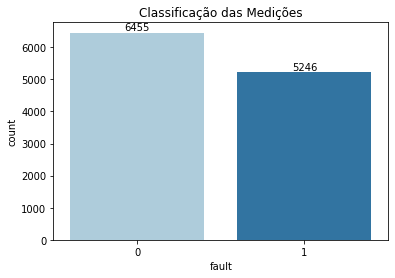

In [254]:
#Utilizaremos a visualização countplot para verificar o balanceamento das classes
ax = sns.countplot(x=df_fault['fault'], palette="Paired")

values_text(ax)
plt.title("Classificação das Medições")
plt.show()

O dataset foi construído com já levando em consideração o balanceamento. Verificaremos então a distribuição de cada feature.

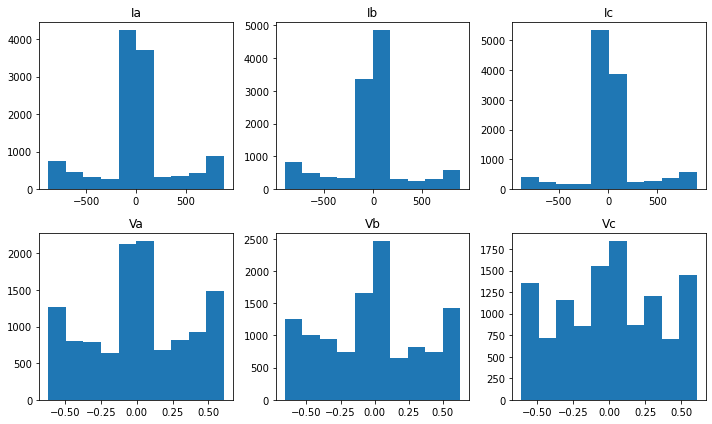

In [255]:
#Plot do histograma de cada coluna
fig, axs = plt.subplots(2, 3,figsize=(10,6))
fig.tight_layout()
columns = df_fault.columns[:6]
count = 0
for j in range(2):
  for i in range(3):
    axs[j, i].hist(x=df_fault[columns[count]])
    axs[j, i].set_title(columns[count])
    plt.tight_layout()
    count +=1

Todas as features possuem uma distribuição aproximadamente Normal. Por fim, verificaremos o relacionamento entre as features.

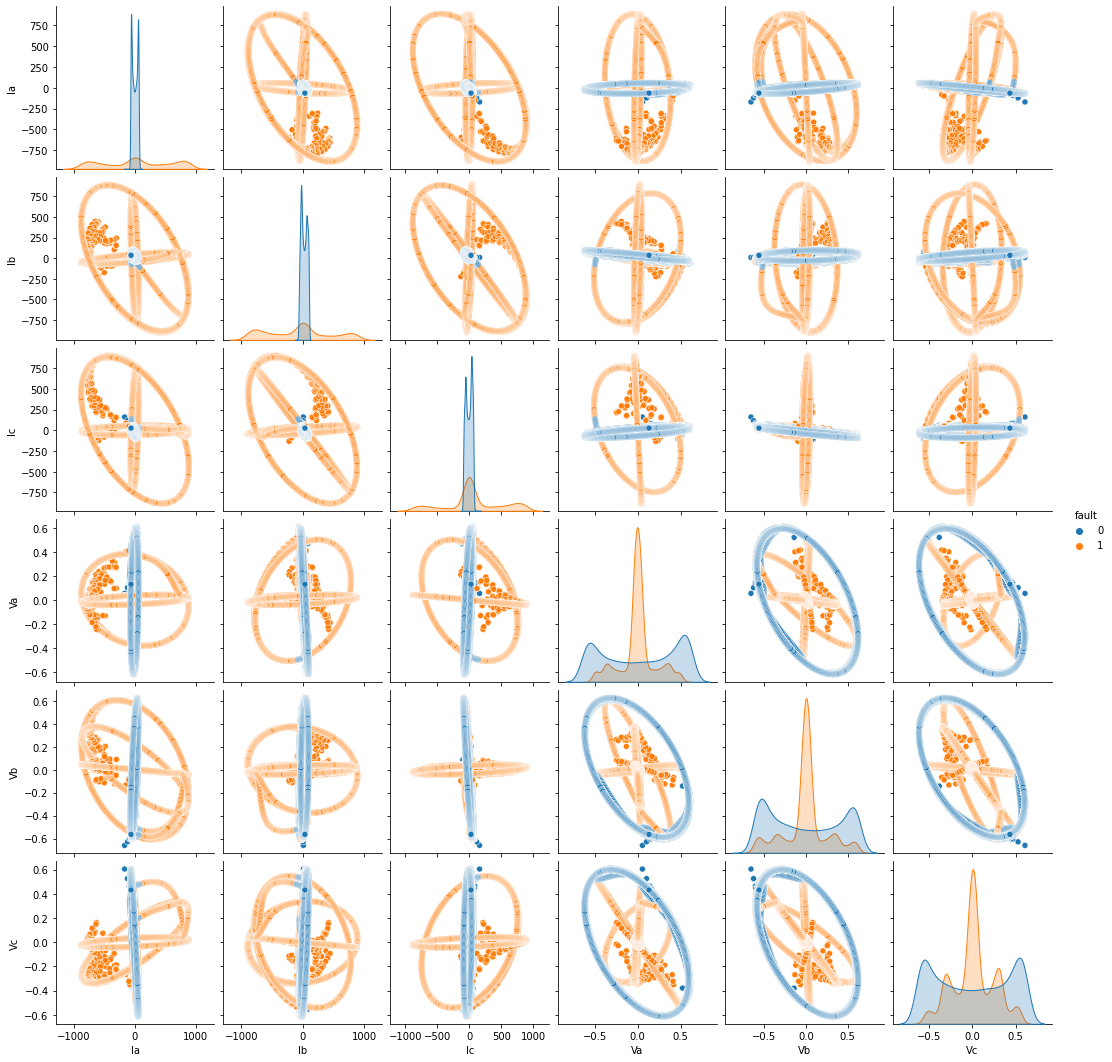

In [256]:
#Plot pairplot
sns.pairplot(df_fault,hue='fault')
plt.show()

Fica claro pelo grafico acima que estamos trabalhando com um problema não linear.

####Dataset 2

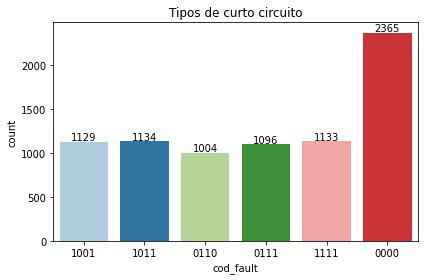

In [257]:
#Utilizaremos a visualização countplot para verificar o balanceamento dos tipos de curto circuito
ax = sns.countplot(x=df_fault_type['cod_fault'], palette="Paired")

values_text(ax)
plt.title("Tipos de curto circuito")
plt.tight_layout()
plt.show()

##Treinamento e teste

###Preparação

In [258]:
features = ['Ia', 'Ib', 'Ic', 'Va', 'Vb', 'Vc']
X = df_fault_detect[features]
y = df_fault_detect['fault']

In [259]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

###Feature engineering

In [260]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif


In [261]:
# Avaliação das features aplicando o teste Anova
test = SelectKBest(score_func=f_classif, k=2)
fit = test.fit(X, y)

#print das features e seus respectivos p-value
for value in [*zip(X.columns, fit.pvalues_)]:
  print(value)


('Ia', 1.5723151027868466e-05)
('Ib', 3.1815815122898957e-49)
('Ic', 9.122919893255427e-40)
('Va', 0.00010603270209366629)
('Vb', 0.1811974226983793)
('Vc', 0.013415618139822094)


###Modelos

####Support Vector Machines

#####Tuning hiperparametros

In [262]:
# Conjunto de valores para os Hiperparametros
params = {
         'C': (1e-0, 1e+3, 'log-uniform'),
         'gamma': (1e-2, 1e+1, 'log-uniform'),
         }

In [263]:
%%time
# Criação da class BayesSearchCV para os parametros escolhidos e tendo o recall como metrica de avaliacao:
BS_SVC = BayesSearchCV(estimator = SVC(),
                       search_spaces = params,
                       scoring='recall',
                       cv = 10,
                       n_iter = 20, 
                       random_state=123)

# Realizando a otimização por BayesSearchCV para a deteccao de curto circuito:
BS_SVC.fit(X_test,y_test)

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


CPU times: user 2min 14s, sys: 6.74 s, total: 2min 20s
Wall time: 2min 13s


In [264]:
# Melhores valores para os paramentros:
print('C: {}'.format(BS_SVC.best_params_['C']))
print('gamma: {}'.format(BS_SVC.best_params_['gamma']))
print('Best Score: {}'.format(BS_SVC.best_score_))

C: 17.257565936464992
gamma: 0.5646310499409866
Best Score: 0.9963235294117647


#####Treinamento, validação e teste

In [265]:
classif_fault_SVM = SVC(C=17.258, gamma=0.565)

In [266]:
classif_fault_SVM.fit(X_train, y_train)

SVC(C=17.258, gamma=0.565)

In [267]:
metricas_SVM = cross_validate(classif_fault_SVM, X_test, y_test, cv=10, scoring=['recall', 'f1'])
print("Recall Score medio:", np.mean(metricas_SVM['test_recall']))
print("f1 Score medio:", np.mean(metricas_SVM['test_f1']))

Recall Score medio: 0.9963235294117647
f1 Score medio: 0.9183643534500222


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


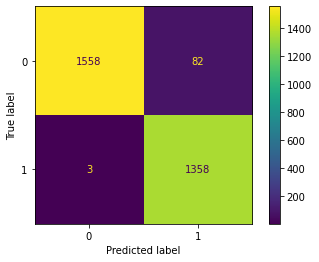

In [268]:
metrics.plot_confusion_matrix(classif_fault_SVM,X_test,y_test)

####Random Forest

#####Tuning de hiperparâmetros

In [269]:
# Conjunto de valores para os Hiperparametros
params = {
    "n_estimators": (1, 5000),
    "max_depth": (1, 100),
    "max_features":(1,6),
    "criterion": ["gini", "entropy"],
}

In [270]:
%%time
# Criação da class BayesSearchCV para os parametros escolhidos e tendo o recall como metrica de avaliacao:
BS_RF = BayesSearchCV(estimator = RandomForestClassifier(),
                       search_spaces = params,
                       scoring='recall',
                       cv = 10,
                       n_iter = 20, 
                       random_state=123)

# Realizando a otimização por BayesSearchCV para a deteccao de curto circuito:
BS_RF.fit(X_test,y_test)

CPU times: user 47min 41s, sys: 14.8 s, total: 47min 56s
Wall time: 47min 45s


In [271]:
# Melhores valores para os paramentros:
print('n_estimators: {}'.format(BS_RF.best_params_['n_estimators']))
print('max_depth: {}'.format(BS_RF.best_params_['max_depth']))
print('criterion: {}'.format(BS_RF.best_params_['criterion']))
print('max_features: {}'.format(BS_RF.best_params_['max_features']))
print('Best Score: {}'.format(BS_RF.best_score_))

n_estimators: 444
max_depth: 70
criterion: gini
max_features: 2
Best Score: 0.994863675397166


#####Treinamento, validação e teste

In [307]:
classif_fault_RF = RandomForestClassifier(n_estimators=444, 
                                          max_depth=70, 
                                          criterion='gini', 
                                          max_features=2)

In [308]:
classif_fault_RF.fit(X_train, y_train)

RandomForestClassifier(max_depth=70, max_features=2, n_estimators=444)

In [274]:
metricas_RF = cross_validate(classif_fault_RF, X_test, y_test, cv=10, scoring=['recall', 'f1'])
print("Recall Score medio:", np.mean(metricas_RF['test_recall']))
print("f1 Score medio:", np.mean(metricas_RF['test_f1']))

Recall Score medio: 0.9948583082868183
f1 Score medio: 0.9952325706274046


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


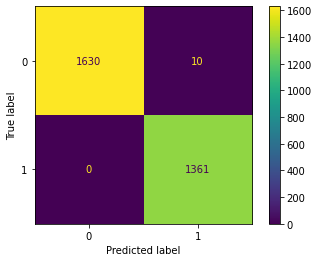

In [275]:
metrics.plot_confusion_matrix(classif_fault_RF,X_test,y_test)

####XGBoost Classifier

#####Tuning hiperparametros

In [276]:
# Conjunto de valores para os Hiperparametros
params = {
    "eta": (0,1),
    "gamma": (0, 200),
    "max_depth": (1, 100),
    'n_estimators':(1,5000),
}


In [277]:
%time
# Criação da class BayesSearchCV para os parametros escolhidos e tendo o recall como metrica de avaliacao:
BS_XGB = BayesSearchCV(estimator = XGBClassifier(),
                       search_spaces = params,
                       scoring='recall',
                       cv = 10,
                       n_iter = 20, 
                       random_state=123)

# Realizando a otimização por BayesSearchCV para a deteccao de curto circuito:
BS_XGB.fit(X_test,y_test)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


BayesSearchCV(cv=10, estimator=XGBClassifier(), n_iter=20, random_state=123,
              scoring='recall',
              search_spaces={'eta': (0, 1), 'gamma': (0, 200),
                             'max_depth': (1, 100), 'n_estimators': (1, 5000)})

In [278]:

# Melhores valores para os paramentros:
print('eta: {}'.format(BS_XGB.best_params_['eta']))
print('gamma: {}'.format(BS_XGB.best_params_['gamma']))
print('max_depth: {}'.format(BS_XGB.best_params_['max_depth']))
print('n_estimators: {}'.format(BS_XGB.best_params_['n_estimators']))
print('Best Score: {}'.format(BS_XGB.best_score_))


eta: 1
gamma: 0
max_depth: 6
n_estimators: 2391
Best Score: 0.9948583082868183


#####Treinamento, validacao e teste

In [279]:
classif_fault_XGB = XGBClassifier(eta=1, 
                                  gamma=0, 
                                  max_depth=6, 
                                  n_estimators=2391)

In [280]:
classif_fault_XGB.fit(X_train, y_train)

XGBClassifier(eta=1, max_depth=6, n_estimators=2391)

In [281]:
metricas_XGB = cross_validate(classif_fault_XGB, X_test, y_test, cv=10, scoring=['recall', 'f1'])
print("Recall Score medio:", np.mean(metricas_XGB['test_recall']))
print("f1 Score medio:", np.mean(metricas_XGB['test_f1']))

Recall Score medio: 0.9948583082868183
f1 Score medio: 0.9955989001616172


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


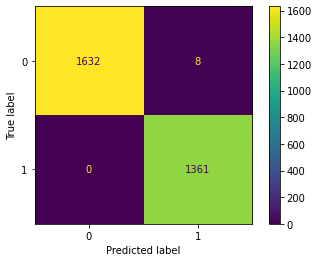

In [282]:
metrics.plot_confusion_matrix(classif_fault_XGB,X_test,y_test)

##Avaliação dos modelos

###Support Vector Machines

In [283]:
#Criando um vetor com as previsoes do classificador SVM tendo como entrada os dados de teste
y_predict_SVM = classif_fault_SVM.predict(df_test[features])

In [284]:
#Criando um coluna com as previsoes SVM
df_test['predict_SVM'] = y_predict_SVM

In [285]:
#Calculo do recall e f1 score com os dados de teste
recall_test_SVM = recall_score(df_test['fault'], y_predict_SVM)
f1_score_test_SVM = f1_score(df_test['fault'], y_predict_SVM)
print('Recall teste: ', round(recall_test_SVM,6))
print('f1 score teste: ', round(f1_score_test_SVM, 6))

Recall teste:  1.0
f1 score teste:  1.0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


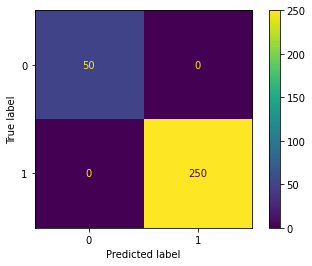

In [286]:
#Matriz de Confusão com o dataframe df_fault_test
metrics.plot_confusion_matrix(classif_fault_SVM, df_test[features], df_test['fault'])

In [287]:
#Criando um dataframe com os registros previstos erradamente
#filtro_SVM = (df_fault_test.fault == 1) & (df_fault_test.predict_SVM == 0)
#erros_SVM = df_fault_test[['cod_fault', 'fault', 'predict_SVM']].loc[filtro_SVM]

In [288]:
#avaliando quais os tipos de curto foram previstos erradamente
#erros_SVM["cod_fault"].value_counts()

###Random Florest

In [289]:
#Criando um vetor com as previsoes do classificador SVM tendo como entrada os dados de teste
y_predict_RF = classif_fault_RF.predict(df_test[features])

In [290]:
#Criando um coluna com as previsoes SVM
df_test['predict_RF'] = y_predict_RF

In [291]:
#Calculo do recall e f1 score com os dados de teste
recall_test_RF = recall_score(df_test['fault'], y_predict_RF)
f1_score_test_RF = f1_score(df_test['fault'], y_predict_RF)
print('Recall teste: ', round(recall_test_RF,6))
print('f1 score teste: ', round(f1_score_test_RF, 6))

Recall teste:  1.0
f1 score teste:  1.0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


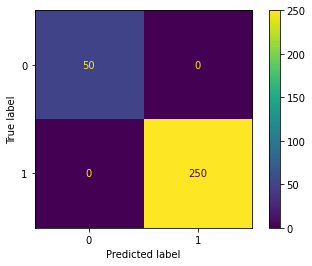

In [292]:
#Matriz de Confusão com o dataframe df_fault_test
metrics.plot_confusion_matrix(classif_fault_RF, df_test[features], df_test['fault'])

###XGBoost

In [293]:
#Criando um vetor com as previsoes do classificador SVM tendo como entrada os dados de teste
y_predict_XGB = classif_fault_XGB.predict(df_test[features])

In [294]:
#Criando um coluna com as previsoes SVM
df_test['predict_XGB'] = y_predict_XGB

In [295]:
#Calculo do recall e f1 score com os dados de teste
recall_test_XGB = recall_score(df_test['fault'], y_predict_XGB)
f1_score_test_XGB = f1_score(df_test['fault'], y_predict_XGB)
print('Recall teste: ', round(recall_test_XGB,6))
print('f1 score teste: ', round(f1_score_test_XGB, 6))

Recall teste:  1.0
f1 score teste:  1.0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


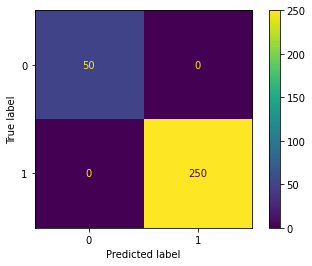

In [296]:
#Matriz de Confusão com o dataframe df_fault_test
metrics.plot_confusion_matrix(classif_fault_XGB, df_test[features], df_test['fault'])

###Comparações e escolha do modelo final

In [313]:
modelos = [metricas_SVM, metricas_RF, metricas_XGB]

In [315]:
#Lista de Recall médio de Validação dos modelos
recall_medio_CV = [round(np.mean(model['test_recall']),6) for model in modelos]

#Lista de Recall minimo de Validação dos modelos
recall_min_CV = [round(model['test_recall'].min(),6) for model in modelos]

#Lista de Recall minimo de Validação dos modelos
recall_max_CV = [round(model['test_recall'].max(),6) for model in modelos]

In [317]:
#Lista de f1 score médio de Validação dos modelos
f1_medio_CV = [round(np.mean(model['test_f1']),6) for model in modelos]

#Lista de f1_score minimo de Validação dos modelos
f1_min_CV = [round(model['test_f1'].min(),6) for model in modelos]

#Lista de Recall minimo de Validação dos modelos
f1_max_CV = [round(model['test_f1'].max(),6) for model in modelos]

In [312]:
#Lista de Recall e f1 score com os dados de teste
recall_test = [recall_test_SVM, recall_test_RF, recall_test_XGB]
f1_score_test = [f1_score_test_SVM, f1_score_test_RF, f1_score_test_XGB]

In [321]:
result_modelos = pd.DataFrame(data = np.transpose([recall_medio_CV,
                                                   recall_min_CV,
                                                   recall_max_CV, 
                                                   f1_medio_CV,
                                                   f1_min_CV,
                                                   f1_max_CV,
                                                   recall_test,
                                                   f1_score_test]),
                              index = ['SVM', 'Random_Forest', 'XGBoost'],
                              columns = ['Recall_medio_CV',
                                         'Recall_min_CV',
                                         'Recall_max_CV', 
                                         'f1_medio_CV',
                                         'f1_min_CV',
                                         'f1_max_CV', 
                                         'Recall_teste',
                                         'f1_teste'])

In [322]:
result_modelos

,Recall_medio_CV,Recall_min_CV,Recall_max_CV,f1_medio_CV,f1_min_CV,f1_max_CV,Recall_teste,f1_teste
SVM,0.996324,0.992647,1.0,0.918364,0.894040,0.944444,1.0,1.0
Random_Forest,0.994858,0.992647,1.0,0.995233,0.989011,1.000000,1.0,1.0
XGBoost,0.994858,0.992647,1.0,0.995599,0.985401,1.000000,1.0,1.0


Levando em consideração todos os três modelos tivem um ótimo desempenho. O critério de desempate será dado pelo desempenho e custo computacional, sendo o modelo XGBoost o escolhido.